In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES)

# Apps

**RQ1:** How many different apps did we see?  
**RQ2:** How many users per app?

## 1. Apps per user

In [4]:
def get_packages(lst):
    packages = []
    for n in lst:
        packages.append(n['packageName'])
    return packages

def worker_get_package_counts(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df.Active = df.Active.apply(get_packages)
    result = df.Active.tolist()
    result = len(set(itertools.chain(*result)))
    return result

In [5]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst_package_counts = p.map(worker_get_package_counts, uuids)

In [6]:
package_counts = pd.Series(lst_package_counts)
package_counts.tail()

3948    35
3949    24
3950    36
3951    33
3952    11
dtype: int64

In [7]:
package_counts.describe()

count    3953.000000
mean       30.912472
std        13.813954
min         4.000000
25%        21.000000
50%        28.000000
75%        37.000000
max       111.000000
dtype: float64

## 2. Users per app

In [8]:
def get_packages(lst):
    packages = []
    for n in lst:
        packages.append(n['packageName'])
    return packages

def worker_get_packages(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df.Active = df.Active.apply(get_packages)
    result = df.Active.tolist()
    result = list(set(itertools.chain(*result)))
    return result

In [9]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_get_packages, uuids)

lst_packages = list(itertools.chain(*lst))
len(lst)

3953

In [10]:
packages = pd.Series(lst_packages, name='PackageName')
packages.tail()

122192    com.android.server.telecom
122193                       android
122194        com.samsung.android.sm
122195                  package.6783
122196          com.android.incallui
Name: PackageName, dtype: object

In [11]:
len(packages.unique())

8823

### Apps with the most users

In [12]:
packages.value_counts(dropna=False).head(10)

com.android.systemui                       3883
android                                    3754
com.whatsapp                               3591
com.android.vending                        3416
com.android.providers.downloads            3030
com.instagram.android                      2962
com.google.android.youtube                 2773
com.android.chrome                         2603
com.google.android.googlequicksearchbox    2555
com.google.android.apps.maps               2381
Name: PackageName, dtype: int64

### Stats on user counts

In [13]:
packages.value_counts(dropna=False).describe()

count    8823.000000
mean       13.849824
std       129.619888
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      3883.000000
Name: PackageName, dtype: float64

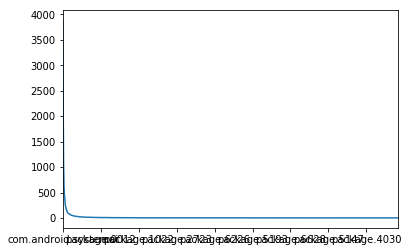

In [14]:
packages.reset_index(drop=True).value_counts(dropna=False).plot()

### Apps with >= 1000 users

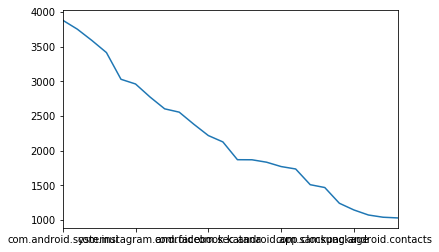

In [15]:
packages1000 = packages.value_counts(dropna=False)
packages1000 = packages1000[packages1000 >= 1000]
packages1000.plot()

In [16]:
len(packages1000)

24

In [17]:
packages1000

com.android.systemui                       3883
android                                    3754
com.whatsapp                               3591
com.android.vending                        3416
com.android.providers.downloads            3030
com.instagram.android                      2962
com.google.android.youtube                 2773
com.android.chrome                         2603
com.google.android.googlequicksearchbox    2555
com.google.android.apps.maps               2381
com.facebook.katana                        2217
com.google.android.gm                      2125
com.samsung.android.incallui               1868
com.android.server.telecom                 1867
com.facebook.orca                          1832
com.sec.android.app.clockpackage           1769
com.samsung.android.messaging              1734
com.google.android.gms                     1507
com.google.android.apps.photos             1466
com.google.android.music                   1239
com.samsung.android.contacts            

### Categories

In [18]:
counts = pd.DataFrame(packages.value_counts(dropna=False))
counts['Count'] = counts.PackageName.astype(int)
counts['PackageName'] = counts.index
counts['Category'] = counts.PackageName.apply(lambda x: '' if x not in category_mapping else category_mapping[x])
counts = counts.sort_values('Count', ascending=False)
counts = counts.reset_index(drop=True)
counts.head(10)

,PackageName,Count,Category
0,com.android.systemui,3883,SYSTEM
1,android,3754,SYSTEM
2,com.whatsapp,3591,SMS/IM
3,com.android.vending,3416,SYSTEM
4,com.android.providers.downloads,3030,SYSTEM
5,com.instagram.android,2962,SOCIAL
6,com.google.android.youtube,2773,MEDIA
7,com.android.chrome,2603,TOOL
8,com.google.android.googlequicksearchbox,2555,TOOL
9,com.google.android.apps.maps,2381,NAVIGATION


In [19]:
counts.tail(5)

,PackageName,Count,Category
8818,package.5909,1,UNKNOWN
8819,package.6307,1,UNKNOWN
8820,package.5312,1,UNKNOWN
8821,package.4801,1,UNKNOWN
8822,package.3580,1,UNKNOWN


In [20]:
print('Apps with >=   10 users: %3d' % len(counts[counts.Count >= 10]))
print('Apps with >=  100 users: %3d' % len(counts[counts.Count >= 100]))
print('Apps with >= 1000 users: %3d' % len(counts[counts.Count >= 1000]))

Apps with >=   10 users: 908
Apps with >=  100 users: 134
Apps with >= 1000 users:  24


In [21]:
'Apps with only one user: %d' % len(counts[counts.Count == 1])

'Apps with only one user: 4962'

In [22]:
print('Median number of users per category:\n')
counts.groupby('Category').Count.agg(np.median)

Median number of users per category:



Category
CALENDAR/REMINDER     43.0
EMAIL                 24.5
GAME                  19.0
HEALTH/FITNESS        17.5
MEDIA                 24.5
NAVIGATION            18.5
NEWS                  18.0
PHONE                133.0
SHOPPING              21.0
SMS/IM                42.0
SOCIAL                35.5
SYSTEM                32.0
TOOL                  21.5
UNKNOWN                1.0
Name: Count, dtype: float64

### Plot users per app

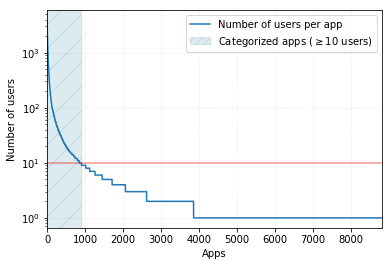

In [23]:
threshold = 10

ax = counts.Count.plot(
    figsize=(6, 4),
    legend=True,
    grid=True
)

ax.set_yscale('log')

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Span and threshold
ax.axvspan(0, 907, color='#539caf', alpha=0.2, hatch='/', rasterized=True)
ax.axhline(threshold, color='r', linestyle='-', alpha=0.4)

# Tweak font sizes
ax.set_xlabel('Apps', fontsize=10)
ax.set_ylabel('Number of users', fontsize=10)
ax.tick_params(labelsize=10)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles+[
    patches.Patch(color='#539caf', alpha=0.2, hatch='///', rasterized=True),
    #mlines.Line2D([], [], color='r', alpha=0.8)
], labels=[
    'Number of users per app',
    'Categorized apps ($\geq10$ users)',
    #'Threshold (10 users)'
], loc='upper right', prop={'size': 10})

plt.savefig('figures/users_per_app.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/users_per_app.pdf', bbox_inches='tight', pad_inches=0)

plt.show()